In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

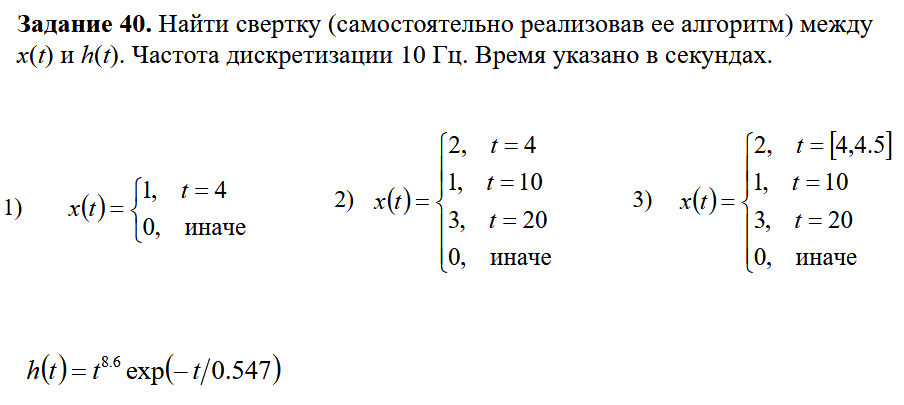

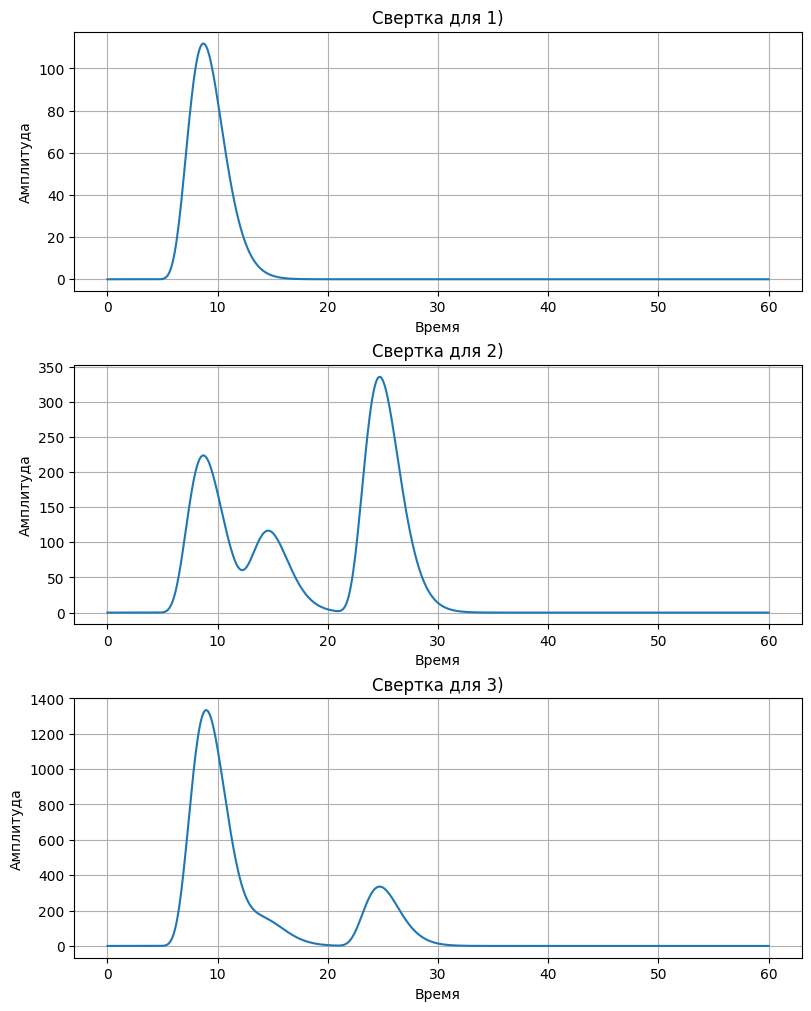

In [7]:
Fs = 10
T = 30
N = T * Fs + 1
t = np.linspace(0, T, N)
h = np.power(t, 8.6) * np.exp(-t / 0.547)

x1 = np.zeros_like(t)
x1[np.isclose(t, 4)] = 1

x2 = np.zeros_like(t)
x2[np.isclose(t, 4)] = 2
x2[np.isclose(t, 10)] = 1
x2[np.isclose(t, 20)] = 3

x3 = np.zeros_like(t)
x3[(t >= 4) & (t <= 4.5)] = 2
x3[np.isclose(t, 10)] = 1
x3[np.isclose(t, 20)] = 3

def convolution(x, h):
    y = np.zeros(len(x) + len(h) - 1)
    for n in range(len(y)):
        s = 0
        for k in range(len(x)):
            if 0 <= n - k < len(h):
                s += x[k] * h[n - k]
        y[n] = s
    return y

y1 = convolution(x1, h)
y2 = convolution(x2, h)
y3 = convolution(x3, h)
t_conv = np.linspace(0, 2 * T, len(y1))

def plot_convolution(ax, t, y, title):
    ax.plot(t, y)
    ax.set_title(title)
    ax.set_xlabel('Время')
    ax.set_ylabel('Амплитуда')
    ax.grid()

fig, axs = plt.subplots(3, 1, figsize=(8, 10), constrained_layout=True)

plot_convolution(axs[0], t_conv, y1, 'Свертка для 1)')
plot_convolution(axs[1], t_conv, y2, 'Свертка для 2)')
plot_convolution(axs[2], t_conv, y3, 'Свертка для 3)')

plt.show()

Свёртка показывает, как система реагирует на заданный входной сигнал  
Каждый импульс входного сигнала вызывает свой отклик — копию импульсной характеристики, сдвинутую во времени и масштабированную по амплитуде  
Результат свёртки — сумма всех таких откликов  

**Первый график:** отклик на единственный импульс — это просто импульсная характеристика, сдвинутая на момент возникновения импульса  
**Второй:** каждый пик — отклик на свой импульс. Между пиками выходной сигнал не опускается до нуля, потому что хвосты откликов от предыдущих импульсов накладываются и суммируются, создавая перекрытие   
**Третий:** здесь есть как точечные импульсы, так и прямоугольный импульс. Прямоугольный импульс можно представить как множество точечных импульсов, каждый из которых вызывает свой отклик. Их сумма даёт более широкий и плавный отклик на графике   



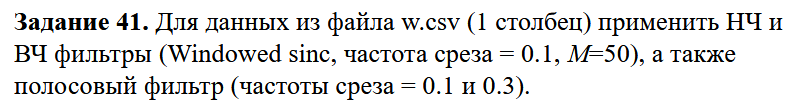

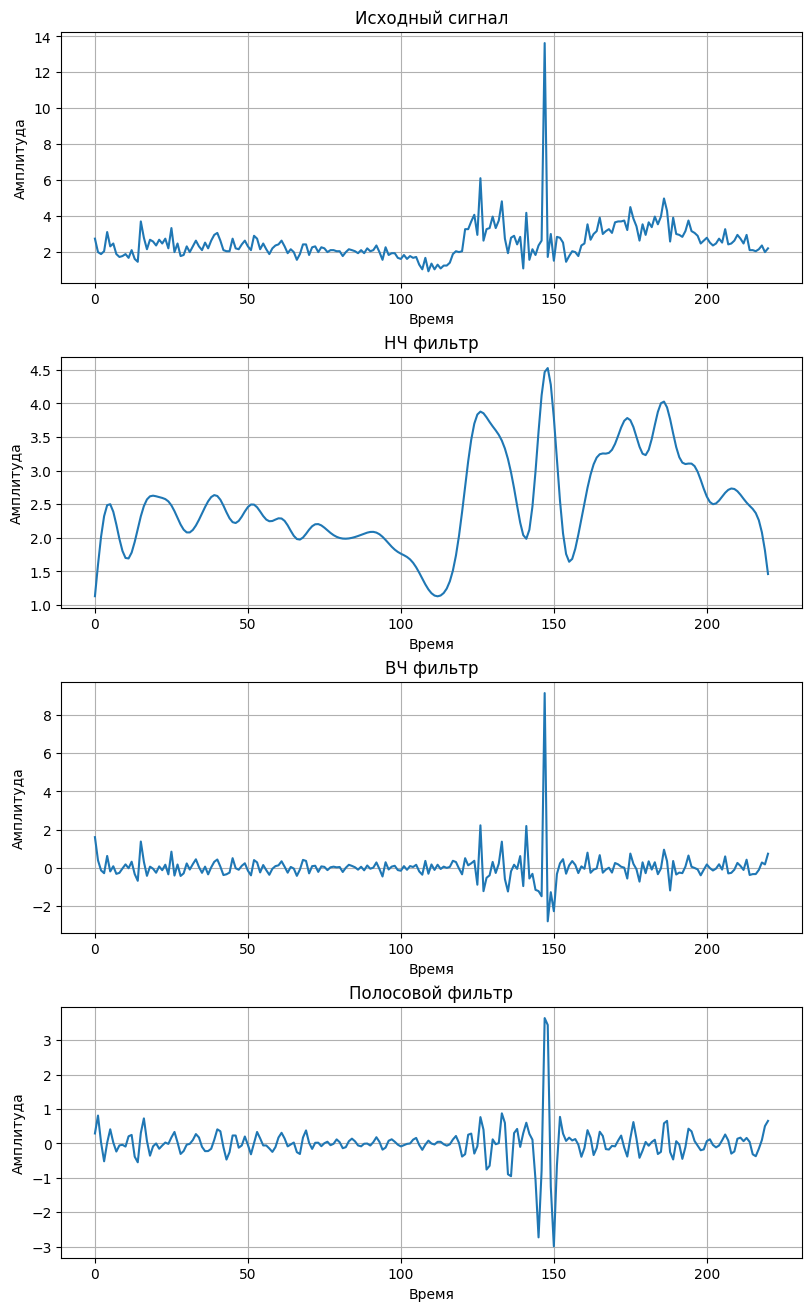

In [8]:
data = pd.read_csv('w.csv', header=None, usecols=[0])
data = data.iloc[:, 0].astype(float).values

fc_low = 0.1
fc_band = [0.1, 0.3]
M = 50

def windowed_sinc_lowpass(fc, M):
    n = np.arange(M)
    h = np.sinc(2 * fc * (n - (M - 1) / 2))
    w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (M - 1)) + 0.08 * np.cos(4 * np.pi * n / (M - 1))
    h = h * w
    h /= np.sum(h)
    return h

def windowed_sinc_highpass(fc, M):
    h_lp = windowed_sinc_lowpass(fc, M)
    h_hp = -h_lp
    h_hp[(M - 1) // 2] += 1
    return h_hp

def windowed_sinc_bandpass(fc1, fc2, M):
    h_lp1 = windowed_sinc_lowpass(fc2, M)
    h_lp2 = windowed_sinc_lowpass(fc1, M)
    h_bp = h_lp1 - h_lp2
    return h_bp

h_low = windowed_sinc_lowpass(fc_low, M)
h_high = windowed_sinc_highpass(fc_low, M)
h_band = windowed_sinc_bandpass(fc_band[0], fc_band[1], M)

y_low = np.convolve(data, h_low, mode='same')
y_high = np.convolve(data, h_high, mode='same')
y_band = np.convolve(data, h_band, mode='same')

def plot_signal(ax, signal, title):
    ax.plot(signal)
    ax.set_title(title)
    ax.set_xlabel('Время')
    ax.set_ylabel('Амплитуда')
    ax.grid(True)

fig, axes = plt.subplots(4, 1, figsize=(8, 13), sharex=False, constrained_layout=True)

plot_signal(axes[0], data, 'Исходный сигнал')
plot_signal(axes[1], y_low, 'НЧ фильтр')
plot_signal(axes[2], y_high, 'ВЧ фильтр')
plot_signal(axes[3], y_band, 'Полосовой фильтр')

plt.show()

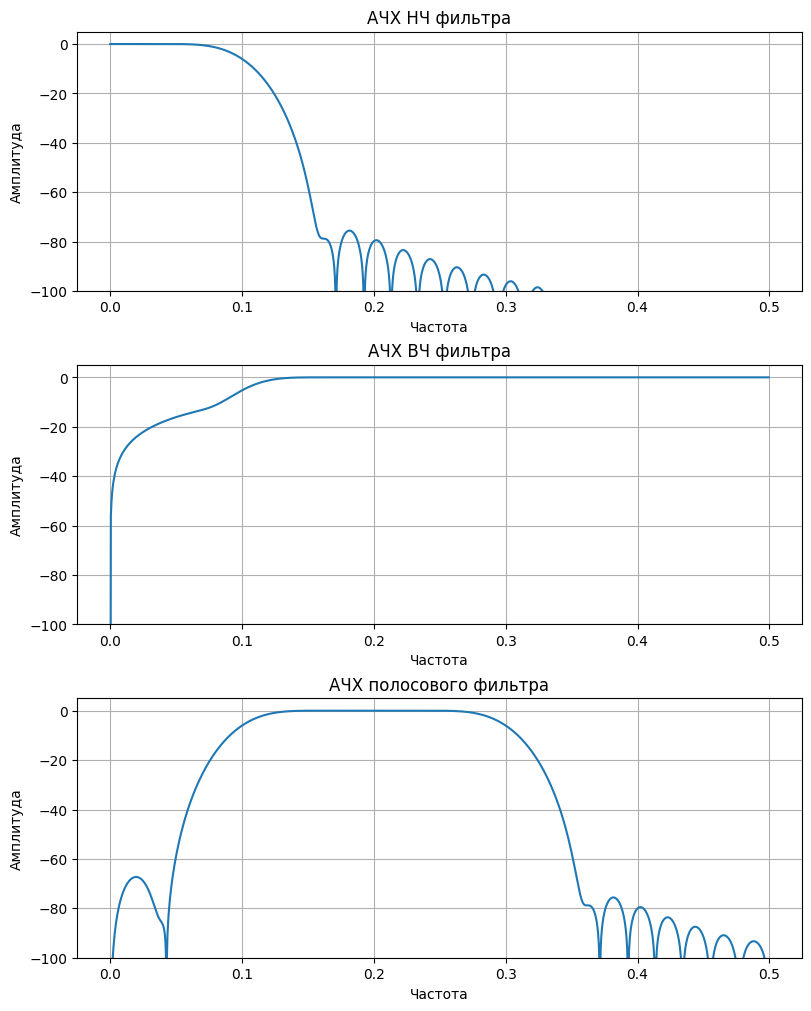

In [9]:
def plot_frequency_response(ax, h, fs, title):
    N_fft = 2048
    H = np.fft.fft(h, N_fft)
    freq = np.fft.fftfreq(N_fft, d=1/fs)

    pos_mask = freq >= 0
    freq_pos = freq[pos_mask]
    H_pos = H[pos_mask]

    amplitude = 20 * np.log10(np.abs(H_pos) + 1e-12)

    ax.plot(freq_pos, amplitude)
    ax.set_title(title)
    ax.set_xlabel('Частота')
    ax.set_ylabel('Амплитуда')
    ax.set_ylim([-100, 5])
    ax.grid()

fig, axs = plt.subplots(3, 1, figsize=(8, 10), constrained_layout=True)

plot_frequency_response(axs[0], h_low, 1.0, title='АЧХ НЧ фильтра')
plot_frequency_response(axs[1], h_high, 1.0, title='АЧХ ВЧ фильтра')
plot_frequency_response(axs[2], h_band, 1.0, title='АЧХ полосового фильтра')

plt.show()

**НЧ фильтр:** сглаживает
*   фильтрованный сигнал стал более гладким, высокочастотные колебания исчезли  
*   пропускается полоса частот от 0—0.1
*   за пределами полосы — затухание более -60 дБ — подавление хорошее
*   характерная рябь вне полосы — следствие конечности окна (эффект Гиббса)

**ВЧ фильтр:** выделяет быстрые изменения
*   на фильтрованном сигнале остались только быстрые изменения
*   подавление частот в полосе 0—0.1, пропускание вне этой полосы
*   около нуля глубокий провал

**Полосовой фильтр:** оставляет только определённый диапазон частот
*   фильтрованный сигнал содержит только частоты заданного частотного диапазона, остальные частоты подавлены
*   пропускная полоса между 0.1—0.3, вне — сильное подавление




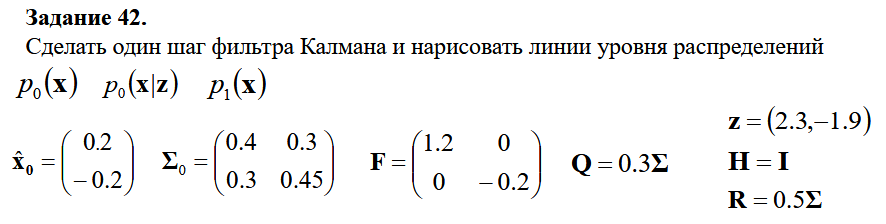

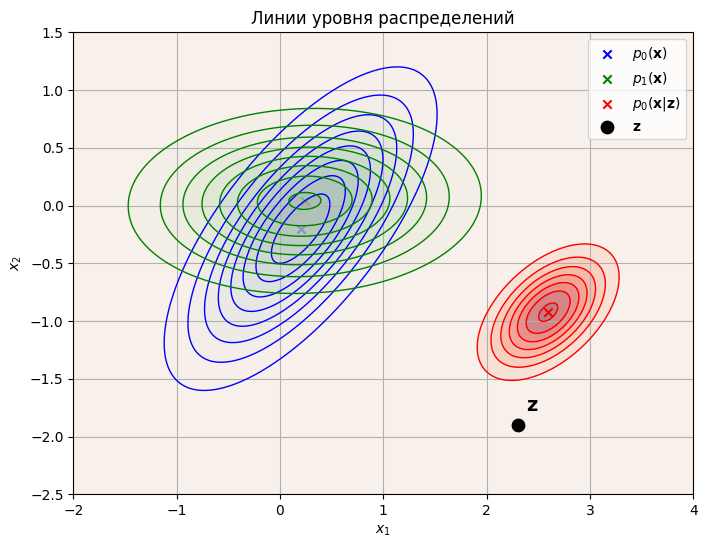

In [11]:
x0 = np.array([0.2, -0.2])
Sigma0 = np.array([[0.4, 0.3], [0.3, 0.45]])
F = np.array([[1.2, 0], [0, -0.2]])
Q = 0.3 * Sigma0
z = np.array([2.3, -1.9])
H = np.eye(2)
R = 0.5 * Sigma0

# Прогнозирование
x_pred = F @ x0
Sigma_pred = F @ Sigma0 @ F.T + Q

# Коррекция
S = H @ Sigma_pred @ H.T + R
K = Sigma_pred @ H.T @ np.linalg.inv(S)
x_upd = x_pred + K @ (z - H @ x_pred)
Sigma_upd = (np.eye(2) - K @ H) @ Sigma_pred

x, y = np.mgrid[-2:4:0.01, -2.5:1.5:0.01]
pos = np.dstack((x, y))

# Распределения
rv0 = multivariate_normal(mean=x0, cov=Sigma0)              # априорное p0(x)
rv_pred = multivariate_normal(mean=x_pred, cov=Sigma_pred)  # прогнозное p1(x)
rv_upd = multivariate_normal(mean=x_upd, cov=Sigma_upd)     # апостериорное p0(x|z)

plt.figure(figsize=(8, 6))

plt.contourf(x, y, rv0.pdf(pos), levels=8, cmap='Blues', alpha=0.4)
plt.contour(x, y, rv0.pdf(pos), levels=8, colors='blue', linewidths=1)
plt.scatter(*x0, color='blue', marker='x', label=r'$p_0(\mathbf{x})$')

plt.contourf(x, y, rv_pred.pdf(pos), levels=8, cmap='Greens', alpha=0.4)
plt.contour(x, y, rv_pred.pdf(pos), levels=8, colors='green', linewidths=1)
plt.scatter(*x_pred, color='green', marker='x', label=r'$p_1(\mathbf{x})$')

plt.contourf(x, y, rv_upd.pdf(pos), levels=8, cmap='Reds', alpha=0.5)
plt.contour(x, y, rv_upd.pdf(pos), levels=8, colors='red', linewidths=1)
plt.scatter(*x_upd, color='red', marker='x', label=r'$p_0(\mathbf{x}|\mathbf{z})$')

plt.scatter(*z, color='black', label=r'$\mathbf{z}$', s=80)
plt.annotate('z', z, textcoords="offset points", xytext=(10, 10), ha='center', fontsize=14, fontweight='bold')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Линии уровня распределений')
plt.legend()
plt.grid()
plt.xlim(-2, 4)
plt.ylim(-2.5, 1.5)
plt.show()

**Априорное распределение** $p_0(\mathbf{x})$ (синее), исходное состояние и ковариация до прогноза и коррекции, начальное знание о состоянии  

**Прогнозное распределение** $p_1(\mathbf{x})$ (зелёное) отражает предсказание, полученное после применения модели динамики $\mathbf{F}$ и добавления шума процесса $\mathbf{Q}$. Эллипсы стали шире (ковариация увеличилась — из-за динамики и шума растет неопределённость), центр смещён согласно матрице $\mathbf{F}$  

**Апостериорное распределение** $p_0(\mathbf{x}\mid\mathbf{z})$ (красное)
сдвинуто в сторону измерения $\mathbf{z}$: обновлённая оценка учитывает новые данные. Ковариация меньше, чем у прогнозного распределения $p_1(\mathbf{x})$ (зелёное) — фильтр уменьшает неопределённость после учёта измерения

Точка измерения $\mathbf{z}$ находится вне априорного и прогнозного центров, объясняя необходимость коррекции